## Step 1: Creating Tokens

Before we can train a language model, the raw text data needs to be broken down into smaller units called tokens. Tokens are the basic building blocks for further processing: they can be characters, words, or subwords depending on the tokenizer design.

In this step, we will read in a sample text file and explore different ways to tokenize it.

Reading the text file
The first step is to load the file into memory and check its length:

In [ ]:
from google.colab import files

# Step 1: Upload the file
uploaded = files.upload()  # Pick the-verdict.txt from your computer

# Step 2: Read the uploaded file
filename = list(uploaded.keys())[0]  # get the uploaded file name dynamically
with open(filename, "r") as f:
    raw_text = f.read()

# Step 3: Print some info
print("Total number of characters:", len(raw_text))
print("First 100 characters preview:\n", raw_text[:100])

Saving the-verdict.txt to the-verdict.txt
Total number of characters: 20479
First 100 characters preview:
 I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no g


**Why Tokenization Matters**

* Raw text cannot be directly processed by a model. It needs to be converted into
numerical form through tokenization and embeddings.

* Different applications may require different tokenization strategies. For example, natural English text often works well with word or subword tokenization, but programming code requires whitespace-sensitive tokenization.

* Scale of training: While state-of-the-art LLMs are trained on terabytes of text, here we work with a single short story to keep the examples simple and runnable on consumer hardware.

**Using Regex for a Simple Tokenizer**

Let’s begin with a toy example before applying tokenization to the full story.
Here, re.split(r'(\s)', text) splits the string into tokens whenever it encounters whitespace. Notice that whitespace itself is retained as separate tokens.

In [ ]:
import re

text = "Hello, world. This, is a test."
result = re.split(r'(\s)', text)
print(result)

['Hello,', ' ', 'world.', ' ', 'This,', ' ', 'is', ' ', 'a', ' ', 'test.']


**Improving the Split**

We can expand the regex to also split on commas and periods:

In [ ]:
result = re.split(r'([,.]|\s)', text)
print(result)

['Hello', ',', '', ' ', 'world', '.', '', ' ', 'This', ',', '', ' ', 'is', ' ', 'a', ' ', 'test', '.', '']


Now words and punctuation are separated, but we also get redundant empty strings and spaces.

**Cleaning the Token List**

To remove noise, we strip whitespace and filter out empty tokens:

In [ ]:
result = [item for item in result if item.strip()]
print(result)

['Hello', ',', 'world', '.', 'This', ',', 'is', 'a', 'test', '.']


**Should We Keep Whitespace?**

When developing a simple tokenizer, whether we should encode whitespaces as separate characters or just remove them depends on our application and its requirements. Removing whitespaces reduces the memory and computing requirements. However, keeping whitespaces can be useful if we train models that are sensitive to the exact structure of the text (for example, Python code, which is sensitive to indentation and spacing). Here, we remove whitespaces for simplicity and brevity of the tokenized outputs. Later, we will switch to a tokenization scheme that includes whitespaces.

The tokenization scheme we devised above works well on the simple sample text. Let's modify it a bit further so that it can also handle other types of punctuation, such as question marks, quotation marks, and the double-dashes we have seen earlier in the first 100 characters of Edith Wharton's short story, along with additional special characters:

**Handling More Punctuation**

Real-world text contains many punctuation symbols such as question marks, dashes, and quotation marks. Let’s extend our regex:

In [ ]:
text = "Hello, world. Is this-- a test?"
result = re.split(r'([,.:;?_!"()\']|--|\s)', text)
result = [item.strip() for item in result if item.strip()]
print(result)

['Hello', ',', 'world', '.', 'Is', 'this', '--', 'a', 'test', '?']


Now our tokenizer correctly handles punctuation and special characters.

**Applying to the Full Story**

Finally, let’s tokenize Edith Wharton’s entire story:

In [ ]:
preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', raw_text)
preprocessed = [item.strip() for item in preprocessed if item.strip()]

print("First 30 tokens:", preprocessed[:30])
print("Total number of tokens:", len(preprocessed))

First 30 tokens: ['I', 'HAD', 'always', 'thought', 'Jack', 'Gisburn', 'rather', 'a', 'cheap', 'genius', '--', 'though', 'a', 'good', 'fellow', 'enough', '--', 'so', 'it', 'was', 'no', 'great', 'surprise', 'to', 'me', 'to', 'hear', 'that', ',', 'in']
Total number of tokens: 4690


📊 **Token Frequency Distribution**

We want to know: How often do different tokens appear in the story?
In natural language, a few words (like "the", "and", "to") appear very frequently, while many appear only once or twice.

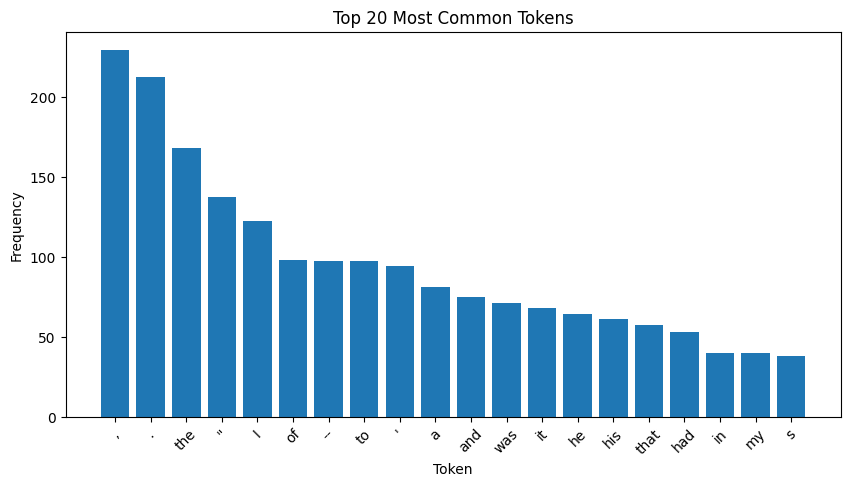

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt

# Count token frequencies
token_counts = Counter(preprocessed)

# Top 20 most common tokens
most_common_tokens = token_counts.most_common(20)

# Plot
tokens, counts = zip(*most_common_tokens)
plt.figure(figsize=(10, 5))
plt.bar(tokens, counts)
plt.title("Top 20 Most Common Tokens")
plt.xlabel("Token")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()

📏 **Token Length Distribution**

Regex tokenization produces tokens of very different lengths (e.g., "I" vs "Gisburn" vs "--"). Let’s check:

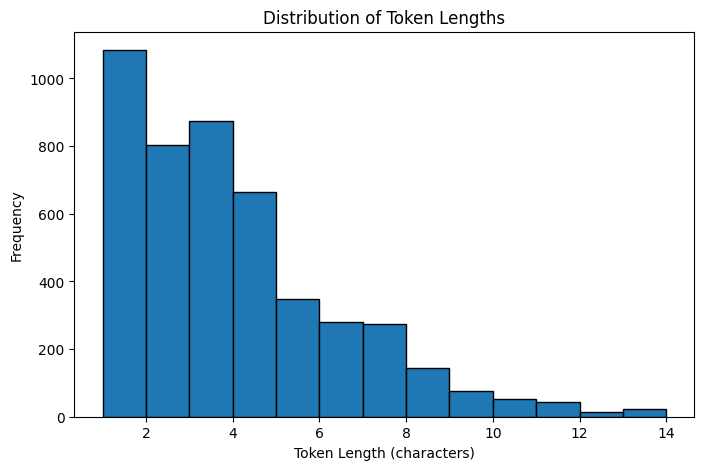

In [ ]:
token_lengths = [len(token) for token in preprocessed]

plt.figure(figsize=(8, 5))
plt.hist(token_lengths, bins=range(1, 15), edgecolor='black')
plt.title("Distribution of Token Lengths")
plt.xlabel("Token Length (characters)")
plt.ylabel("Frequency")
plt.show()

**Why This Matters**

Regex tokenization is rule-based and brittle. It can’t generalize well across different domains (e.g., handling emojis, hashtags, hyphenated words, or Unicode).

Modern tokenizers like BPE (Byte Pair Encoding) or WordPiece fix this by:

* Breaking rare words into subwords (e.g., "Gisburn" → "Gis" + "burn").

* Keeping common words intact.

* Ensuring consistent vocabulary size.

This is why LLMs prefer subword tokenization instead of raw regex or whitespace splitting.

## Step 2: Creating Token IDs

In the previous step, we tokenized Edith Wharton’s short story into a list of tokens and stored it in a variable called preprocessed.
Now, we move one step further: mapping these tokens to integers (token IDs), which is the format LLMs actually work with.

 **Building the Vocabulary**

A vocabulary is the set of all unique tokens in our dataset.
We sort these tokens alphabetically to get reproducible ordering.

In [ ]:
all_words = sorted(set(preprocessed))
vocab_size = len(all_words)

print("Vocabulary size:", vocab_size)

Vocabulary size: 1130


**Creating the Token → ID Mapping**

We assign each token a unique integer ID using Python dictionaries.

In [ ]:
vocab = {token: idx for idx, token in enumerate(all_words)}

# Print the first 51 entries
for i, item in enumerate(vocab.items()):
    print(item)
    if i >= 50:
        break

('!', 0)
('"', 1)
("'", 2)
('(', 3)
(')', 4)
(',', 5)
('--', 6)
('.', 7)
(':', 8)
(';', 9)
('?', 10)
('A', 11)
('Ah', 12)
('Among', 13)
('And', 14)
('Are', 15)
('Arrt', 16)
('As', 17)
('At', 18)
('Be', 19)
('Begin', 20)
('Burlington', 21)
('But', 22)
('By', 23)
('Carlo', 24)
('Chicago', 25)
('Claude', 26)
('Come', 27)
('Croft', 28)
('Destroyed', 29)
('Devonshire', 30)
('Don', 31)
('Dubarry', 32)
('Emperors', 33)
('Florence', 34)
('For', 35)
('Gallery', 36)
('Gideon', 37)
('Gisburn', 38)
('Gisburns', 39)
('Grafton', 40)
('Greek', 41)
('Grindle', 42)
('Grindles', 43)
('HAD', 44)
('Had', 45)
('Hang', 46)
('Has', 47)
('He', 48)
('Her', 49)
('Hermia', 50)


**Why Token IDs?**

Neural networks cannot process raw text → they need numeric input.
Token IDs are the bridge between raw text and embeddings.

Without IDs, there’s no consistent way to look up embeddings during training.
Later in this book, when we want to convert the outputs of an LLM from numbers back into text, we also need a way to turn token IDs into text.

For this, we can create an inverse version of the vocabulary that maps token IDs back to corresponding text tokens.


**Creating the Inverse Vocabulary**

When generating outputs, the model predicts IDs, which we must convert back to text.
So we also need an inverse mapping:

In [ ]:
inverse_vocab = {idx: token for token, idx in vocab.items()}

Later in this book, when we want to convert the outputs of an LLM from numbers back into text, we also need a way to turn token IDs into text.

For this, we can create an inverse version of the vocabulary that maps token IDs back to corresponding text tokens.

Let's implement a complete tokenizer class in Python.

The class will have an encode method that splits text into tokens and carries out the string-to-integer mapping to produce token IDs via the vocabulary.

In addition, we implement a decode method that carries out the reverse integer-to-string mapping to convert the token IDs back into text.

Step 1: Store the vocabulary as a class attribute for access in the encode and decode methods

Step 2: Create an inverse vocabulary that maps token IDs back to the original text tokens

Step 3: Process input text into token IDs

Step 4: Convert token IDs back into text

Step 5: Replace spaces before the specified punctuation

**Implementing a Simple Tokenizer Class**

To bundle this functionality, we’ll create a SimpleTokenizerV1 class.

In [ ]:
import re

class SimpleTokenizerV1:
    def __init__(self, vocab):
        # Forward mapping: string → ID
        self.str_to_int = vocab
        # Inverse mapping: ID → string
        self.int_to_str = {i: s for s, i in vocab.items()}

    def encode(self, text):
        # Step 1: Split input text into tokens (same regex as before)
        preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', text)
        preprocessed = [item.strip() for item in preprocessed if item.strip()]

        # Step 2: Convert tokens into IDs
        ids = [self.str_to_int[s] for s in preprocessed]
        return ids

    def decode(self, ids):
        # Step 3: Convert IDs back into text
        text = " ".join([self.int_to_str[i] for i in ids])

        # Step 4: Post-process spacing before punctuation
        text = re.sub(r'\s+([,.?!"()\'])', r'\1', text)
        return text

**Trying the Tokenizer**

Let’s encode a passage from the story:

In [ ]:
tokenizer = SimpleTokenizerV1(vocab)

text = """"It's the last he painted, you know,"
           Mrs. Gisburn said with pardonable pride."""
ids = tokenizer.encode(text)
print(ids)

[1, 56, 2, 850, 988, 602, 533, 746, 5, 1126, 596, 5, 1, 67, 7, 38, 851, 1108, 754, 793, 7]


**Decoding Back to Text**

In [ ]:
decoded_text = tokenizer.decode(ids)
print(decoded_text)

" It' s the last he painted, you know," Mrs. Gisburn said with pardonable pride.


**Handling Out-of-Vocabulary (OOV) Words**

What if we try to encode new text not present in the training story?

In [ ]:
text = "Hello, do you like tea?"
print(tokenizer.encode(text))

KeyError: 'Hello'

**Problem:**
The word "Hello" was never in our training text.
Since "Hello" does not exist in the vocabulary, Python will throw a KeyError.

 This is a fundamental limitation: small vocabularies cannot handle unseen words.

### ADDING SPECIAL CONTEXT TOKENS
In the previous section, we implemented a simple tokenizer and applied it to a passage from the training set.

In this section, we will modify this tokenizer to handle unknown words.

In this step, we extend our tokenizer to handle special cases:

<|unk|> → used when a token (word or symbol) is not present in our vocabulary.

<|endoftext|> → used to separate unrelated texts (important when training on multiple documents).

Why this matters:

Without <|unk|>, any unseen word cannot be encoded → the model fails to handle it.

Without <|endoftext|>, multiple books or documents get merged into one continuous text, which confuses the model about boundaries.

In [ ]:
# Extend vocab with special tokens
all_tokens = sorted(list(set(preprocessed)))
all_tokens.extend(["<|endoftext|>", "<|unk|>"])

vocab = {token: integer for integer, token in enumerate(all_tokens)}

print("Vocab size:", len(vocab))
print("Last few vocab entries:", list(vocab.items())[-5:])

Vocab size: 1132
Last few vocab entries: [('younger', 1127), ('your', 1128), ('yourself', 1129), ('<|endoftext|>', 1130), ('<|unk|>', 1131)]


We now implement a tokenizer that:

Splits text into tokens (words, punctuation, whitespace).

Replaces unknown tokens with <|unk|>.

Encodes them into integer IDs.

Decodes them back into text, while removing extra spaces before punctuation.

In [ ]:
class SimpleTokenizerV2:
    def __init__(self, vocab):
        self.str_to_int = vocab
        self.int_to_str = { i:s for s,i in vocab.items()}

    def encode(self, text):
        preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', text)
        preprocessed = [item.strip() for item in preprocessed if item.strip()]
        preprocessed = [
            item if item in self.str_to_int
            else "<|unk|>" for item in preprocessed
        ]

        ids = [self.str_to_int[s] for s in preprocessed]
        return ids

    def decode(self, ids):
        text = " ".join([self.int_to_str[i] for i in ids])
        # Replace spaces before the specified punctuations
        text = re.sub(r'\s+([,.:;?!"()\'])', r'\1', text)
        return text

In [ ]:
tokenizer = SimpleTokenizerV2(vocab)

text1 = "Hello, do you like tea?"
text2 = "In the sunlit terraces of the palace."

text = " <|endoftext|> ".join((text1, text2))

print(text)

Hello, do you like tea? <|endoftext|> In the sunlit terraces of the palace.


**Observations**

Unknown handling: Words missing from the training set are collapsed into <|unk|>.

Separation: <|endoftext|> ensures document boundaries are explicit.

Vocabulary growth: Adding just two tokens increased vocab size from 1130 → 1132.

Trade-off: This system works, but <|unk|> loses information. For example, "palace" becomes completely indistinguishable from "Hello".

So far, we have discussed tokenization as an essential step in processing text as input to LLMs. Depending on the LLM, some researchers also consider additional special tokens such as the following:

[BOS] (beginning of sequence): This token marks the start of a text. It signifies to the LLM where a piece of content begins.

[EOS] (end of sequence): This token is positioned at the end of a text, and is especially useful when concatenating multiple unrelated texts, similar to <|endoftext|>. For instance, when combining two different Wikipedia articles or books, the [EOS] token indicates where one article ends and the next one begins.

[PAD] (padding): When training LLMs with batch sizes larger than one, the batch might contain texts of varying lengths. To ensure all texts have the same length, the shorter texts are extended or "padded" using the [PAD] token, up to the length of the longest text in the batch.

Note that the tokenizer used for GPT models does not need any of these tokens mentioned above but only uses an <|endoftext|> token for simplicity

the tokenizer used for GPT models also doesn't use an <|unk|> token for outof-vocabulary words. Instead, GPT models use a byte pair encoding tokenizer, which breaks down words into subword units

### Byte-Pair Encoding

In previous sections, our SimpleTokenizerV2 used <|unk|> to handle unknown words. This meant we lost information whenever a word was unseen.

Modern LLMs avoid <|unk|> entirely by using Byte Pair Encoding (BPE).

Key idea:

* Break words into subword units instead of replacing them with <|unk|>.

* Frequently used words stay intact ("hello" → one token).

* Rare or unknown words are broken into sub-parts ("someunknownPlace" → "some" + "unknown" + "Place").

* Every text can always be encoded, since the fallback is at the byte/character level.

GPT-2, GPT-3, and early ChatGPT models all use this scheme, implemented efficiently in the tiktoken library.

In [ ]:
! pip3 install tiktoken

In [ ]:
import tiktoken
import importlib

# Load GPT-2 BPE tokenizer
tokenizer = tiktoken.get_encoding("gpt2")

print("tiktoken version:", importlib.metadata.version("tiktoken"))
print("Vocabulary size:", tokenizer.n_vocab)  # should be 50,257

tiktoken version: 0.11.0
Vocabulary size: 50257


Notice that the GPT-2 BPE tokenizer has a vocabulary size of 50,257.
The very last ID (50256) is reserved for the special <|endoftext|> token.

In [ ]:
text = "Hello, do you like tea? <|endoftext|> In the sunlit terraces of someunknownPlace."

# Encode with BPE
ids = tokenizer.encode(text, allowed_special={"<|endoftext|>"})
decoded = tokenizer.decode(ids)

print("Original text:", text)
print("Token IDs:", ids)
print("Decoded text:", decoded)

Original text: Hello, do you like tea? <|endoftext|> In the sunlit terraces of someunknownPlace.
Token IDs: [15496, 11, 466, 345, 588, 8887, 30, 220, 50256, 554, 262, 4252, 18250, 8812, 2114, 286, 617, 34680, 27271, 13]
Decoded text: Hello, do you like tea? <|endoftext|> In the sunlit terraces of someunknownPlace.


Observations

<|endoftext|> gets ID 50256, the last entry in the vocabulary.

"someunknownPlace" is not in vocabulary, but BPE breaks it into multiple valid subwords.

Unlike our earlier tokenizer, no <|unk|> symbol is used — information is preserved.

In [ ]:
ids2 = tokenizer.encode("Akwirw ier")
decoded2 = tokenizer.decode(ids2)

print("Token IDs:", ids2)
print("Decoded text:", decoded2)

Token IDs: [33901, 86, 343, 86, 220, 959]
Decoded text: Akwirw ier


"Akwirw" is unknown → split into smaller subword units.

"ier" may be recognized as a frequent suffix and encoded directly.

The decoded output matches the original, proving no information was lost.

Text: someunknownPlace
Token IDs: [11246, 34680, 27271]
Tokens: ['some', 'unknown', 'Place']


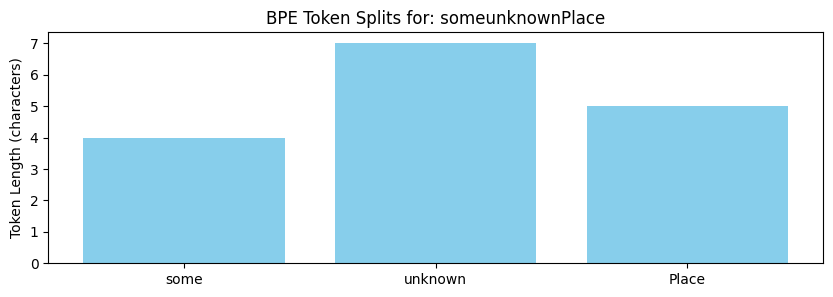

Text: Akwirw ier
Token IDs: [33901, 86, 343, 86, 220, 959]
Tokens: ['Ak', 'w', 'ir', 'w', ' ', 'ier']


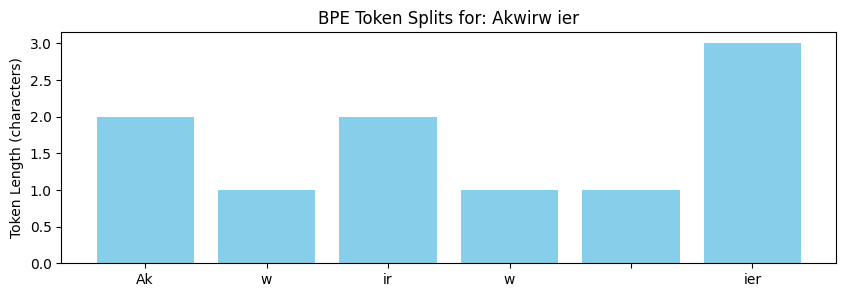

In [ ]:
def visualize_bpe(text):
    ids = tokenizer.encode(text)
    tokens = [tokenizer.decode([i]) for i in ids]

    print("Text:", text)
    print("Token IDs:", ids)
    print("Tokens:", tokens)

    # Plot
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10,3))
    plt.bar(range(len(tokens)), [len(t) for t in tokens], tick_label=tokens, color="skyblue")
    plt.title(f"BPE Token Splits for: {text}")
    plt.ylabel("Token Length (characters)")
    plt.show()

visualize_bpe("someunknownPlace")
visualize_bpe("Akwirw ier")

Subword decomposition: Unknown words get split into manageable, known pieces.

Consistency: Frequent tokens like "ier" or "some" appear across contexts.

No <|unk|>: Every input is guaranteed to be representable.

Scalability: With ~50k tokens, BPE balances efficiency and flexibility.

We can make two noteworthy observations based on the token IDs and decoded text above.

First, the <|endoftext|> token is assigned a relatively large token ID, namely, 50256.

In fact, the BPE tokenizer, which was used to train models such as GPT-2, GPT-3, and the original model used in ChatGPT, has a total vocabulary size of 50,257, with <|endoftext|> being assigned the largest token ID.

Second, the BPE tokenizer above encodes and decodes unknown words, such as "someunknownPlace" correctly.

The BPE tokenizer can handle any unknown word. How does it achieve this without using <|unk|> tokens?

The algorithm underlying BPE breaks down words that aren't in its predefined vocabulary into smaller subword units or even individual characters.

The enables it to handle out-ofvocabulary words.

So, thanks to the BPE algorithm, if the tokenizer encounters an unfamiliar word during tokenization, it can represent it as a sequence of subword tokens or characters

**Byte-Pair Encoding (BPE) — in-depth theory + worked example (Scratch)**
High-level summary (again): Start with symbol inventory = characters (or bytes). Represent each word as sequence of symbols plus an end-of-word marker (e.g., </w>). At each step:

Count all adjacent symbol pairs across the vocabulary and their frequencies.
Pick the most frequent pair and merge it into a new symbol (concatenate).
Repeat for N merges (hyperparameter controls final vocab granularity).
Why add </w>? Without an end-of-word marker, merges could accidentally combine characters across word boundaries when we treat the whole corpus differently. The marker preserves word boundaries in training representation.

Worked mini-example: Corpus: ['low', 'lower', 'lowest', 'newer'] (show full merge steps conceptually).

Initialize: l o w </w>, l o w e r </w>, l o w e s t </w>, n e w e r </w>.
Count pairs, find highest frequency pair (e.g., l o maybe) and merge -> lo w </w> etc.
After a few merges you may obtain subwords like low, low er, new er depending on frequencies. Result: subwords capture frequent morphemes and decrease sequence length for common tokens.

In [ ]:
# ============================================
# STEP 1 — Raw text
# ============================================
text = (
    "Hello, do you like tea? <|endoftext|> In the sunlit terraces "
    "of someunknownPlace."
)

# ============================================
# STEP 2 — Whitespace tokenization
# ============================================
# We split on spaces to get basic words (no punctuation cleaning for now).
ws_tokens = text.split()

print("Whitespace tokens:", ws_tokens)

# ============================================
# STEP 3 — Word frequency counts
# ============================================
from collections import Counter
ws_counts = Counter(ws_tokens)

print("Top word frequencies:", ws_counts.most_common(5))

# ============================================
# STEP 4 — Character-level BPE training
# ============================================
from collections import Counter

def get_vocab_from_words(words):
    vocab = Counter()
    for w in words:
        chars = list(w)
        token = tuple(chars + ['</w>'])  # </w> = word boundary
        vocab[token] += 1
    return vocab

def get_pair_stats(vocab):
    pairs = Counter()
    for word, freq in vocab.items():
        symbols = list(word)
        for i in range(len(symbols)-1):
            pairs[(symbols[i], symbols[i+1])] += freq
    return pairs

def merge_vocab_once(vocab, pair_to_merge):
    a, b = pair_to_merge
    new_vocab = Counter()
    for word, freq in vocab.items():
        symbols = list(word)
        i = 0
        new_symbols = []
        while i < len(symbols):
            if i < len(symbols)-1 and symbols[i] == a and symbols[i+1] == b:
                new_symbols.append(a+b)
                i += 2
            else:
                new_symbols.append(symbols[i])
                i += 1
        new_vocab[tuple(new_symbols)] += freq
    return new_vocab

def bpe_train_char(words, num_merges=100):
    vocab = get_vocab_from_words(words)
    merges = []
    vocab_sizes = [sum(len(w) for w in vocab)]
    for step in range(num_merges):
        pairs = get_pair_stats(vocab)
        if not pairs:
            break
        best_pair, best_freq = pairs.most_common(1)[0]
        merges.append(best_pair)
        vocab = merge_vocab_once(vocab, best_pair)
        vocab_sizes.append(sum(len(w) for w in vocab))
    return merges, vocab, vocab_sizes

# ============================================
# STEP 5 — Train BPE
# ============================================
# We select all unique words from whitespace tokens
unique_words = list(set(ws_tokens))

# Keep top-N most frequent words (all in this toy example)
train_words = sorted(unique_words, key=lambda w: -ws_counts[w])

char_merges, char_final_vocab, char_vocab_sizes = bpe_train_char(train_words, num_merges=50)

print("Learned char-level merges:", len(char_merges))
print("Sample (first 10) merges:", char_merges[:10])

Whitespace tokens: ['Hello,', 'do', 'you', 'like', 'tea?', '<|endoftext|>', 'In', 'the', 'sunlit', 'terraces', 'of', 'someunknownPlace.']
Top word frequencies: [('Hello,', 1), ('do', 1), ('you', 1), ('like', 1), ('tea?', 1)]
Learned char-level merges: 50
Sample (first 10) merges: [('t', 'e'), ('u', 'n'), ('l', 'i'), ('e', '</w>'), ('a', 'c'), ('ac', 'e'), ('d', 'o'), ('s', 'un'), ('sun', 'li'), ('sunli', 't')]


### Byte-level BPE



In standard BPE, tokenization is usually based on Unicode characters (words, subwords).

Byte-level BPE instead works directly at the byte level (raw UTF-8 encoded bytes).

This means:

* Every token corresponds to a sequence of bytes.

* No dependency on Unicode or language-specific preprocessing.

* Handles any language and even emojis or corrupted text.

Why Byte-Level BPE?

Advantages:

* Language agnostic: Works for any language without extra rules.

* Handles out-of-vocabulary words: Breaks unknown words into bytes/subwords.

* Consistent handling of rare characters, emojis, punctuation, and special symbols.

Disadvantage:

* Slightly longer token sequences than standard BPE.

### 📝 Byte Pair Encoding (BPE) vs Byte-Level BPE — Complete Overview

We’ll explore both Standard BPE and Byte-Level BPE step-by-step using a mini corpus, with theory and examples in one unified cell.

---

**Mini Corpus:**
```
low
lowest
new
newer
widest
```

**Part A — Standard BPE Simulation**

1. **Start with characters**
   - Treat each word as a sequence of characters + special end-of-word token `</w>`.
```
low      → l o w </w>
lowest   → l o w e s t </w>
new      → n e w </w>
newer    → n e w e r </w>
widest   → w i d e s t </w>
```

2. **Count pairs**
```
('l','o'): 2  
('o','w'): 2  
('w','</w>'): 1  
('e','s'): 2  
('s','t'): 2
```

3. **Merge the most frequent pair**
   - Merge ('l','o') → "lo"
```
low      → lo w </w>
lowest   → lo w e s t </w>
new      → n e w </w>
newer    → n e w e r </w>
widest   → w i d e s t </w>
```

4. **Repeat merges**
   - Next merge: ('lo','w') → "low"
```
low      → low </w>
lowest   → low e s t </w>
new      → n e w </w>
newer    → n e w e r </w>
widest   → w i d e s t </w>
```
   - Next merge: ('e','s') → "es"
```
low      → low </w>
lowest   → low es t </w>
new      → n e w </w>
newer    → n e w e r </w>
widest   → w i d es t </w>
```
Continue until desired vocabulary size is reached.

**Example resulting vocabulary:**
```
["low", "es", "t", "n", "e", "w", "er", "wid", "est"]
```

**Part B — Byte-Level BPE Simulation**

1. **Convert words to UTF-8 bytes**
```
"low"      → [108, 111, 119]
"lowest"   → [108, 111, 119, 101, 115, 116]
"new"      → [110, 101, 119]
"newer"    → [110, 101, 119, 101, 114]
"widest"   → [119, 105, 100, 101, 115, 116]
```

2. **Count adjacent byte pairs**
```
(108,111): 2
(111,119): 2
(119,101): 2
(101,115): 2
(115,116): 2
```

3. **Merge the most frequent pair**
   - Merge (108,111) → tokenA
```
"low"      → [tokenA, 119]
"lowest"   → [tokenA, 119, 101, 115, 116]
"new"      → [110, 101, 119]
"newer"    → [110, 101, 119, 101, 114]
"widest"   → [119, 105, 100, 101, 115, 116]
```

4. **Repeat merges**
   - Merge (tokenA,119) → tokenB
```
"low"      → [tokenB]
"lowest"   → [tokenB, 101, 115, 116]
"new"      → [110, 101, 119]
"newer"    → [110, 101, 119, 101, 114]
"widest"   → [119, 105, 100, 101, 115, 116]
```
   - Merge (101,115) → tokenC
```
"low"      → [tokenB]
"lowest"   → [tokenB, tokenC, 116]
"new"      → [110, 101, 119]
"newer"    → [110, 101, 119, 101, 114]
"widest"   → [119, 105, 100, tokenC, 116]
```

Continue until target vocabulary size is reached.

**Example resulting vocabulary:**
```
[tokenB, tokenC, tokenD, tokenE, tokenF, ...]
```

**Part C — Side-by-Side Summary**

| Step          | Standard BPE                 | Byte-Level BPE                      |
|---------------|--------------------------------|--------------------------------------|
| Input unit    | Characters + `</w>`         | Bytes                                |
| Merge process | Characters or subwords       | Byte pairs                           |
| Vocabulary    | Subwords                     | Byte sequences                       |
| Example       | "lowest" → ["low","est"]| "lowest" → [tokenB, tokenC, 116]  |
| Language      | Needs Unicode preprocessing  | Works with any language/encoding    |

**Big Takeaway:**
The main difference is the base unit:
- Standard BPE → characters
- Byte-Level BPE → bytes

Byte-Level BPE is encoding-agnostic and works for any language without extra preprocessing.


In [ ]:
import collections

# ---------- Stage 1 — Prepare corpus ----------
corpus = [
    "low",
    "lowest",
    "new",
    "newer",
    "widest"
]

# Convert corpus to byte sequences
byte_corpus = [list(word.encode("utf-8")) for word in corpus]

print("Initial byte representation:")
for word, byte_seq in zip(corpus, byte_corpus):
    print(f"{word}: {byte_seq}")


# ---------- Stage 2 — BPE Merge Algorithm ----------
def get_pair_frequencies(corpus_bytes):
    """Count frequencies of adjacent byte pairs."""
    pairs = collections.Counter()
    for word_bytes in corpus_bytes:
        for i in range(len(word_bytes) - 1):
            pairs[(word_bytes[i], word_bytes[i + 1])] += 1
    return pairs

def merge_pair(pair, corpus_bytes):
    """Merge the given pair in corpus."""
    new_corpus = []
    for word_bytes in corpus_bytes:
        i = 0
        new_word = []
        while i < len(word_bytes):
            # If pair matches → merge
            if i < len(word_bytes) - 1 and (word_bytes[i], word_bytes[i + 1]) == pair:
                new_word.append((word_bytes[i], word_bytes[i + 1]))
                i += 2
            else:
                new_word.append(word_bytes[i])
                i += 1
        new_corpus.append(new_word)
    return new_corpus


# ---------- Stage 3 — Run BPE ----------
vocab = set()
merges = []
corpus_bytes_current = byte_corpus

NUM_MERGES = 5  # Limit merges for demonstration

print("\nBPE Merging steps:")
for merge_step in range(NUM_MERGES):
    pair_freqs = get_pair_frequencies(corpus_bytes_current)
    if not pair_freqs:
        break

    most_frequent_pair = max(pair_freqs, key=pair_freqs.get)
    merges.append(most_frequent_pair)

    print(f"\nStep {merge_step + 1}: Most frequent pair = {most_frequent_pair} with frequency {pair_freqs[most_frequent_pair]}")

    corpus_bytes_current = merge_pair(most_frequent_pair, corpus_bytes_current)

    print("Corpus after merge:")
    for i, word in enumerate(corpus_bytes_current):
        print(f"{corpus[i]}: {word}")

    vocab.update(merges)

print("\nFinal Vocabulary of Merges:")
print(vocab)

Initial byte representation:
low: [108, 111, 119]
lowest: [108, 111, 119, 101, 115, 116]
new: [110, 101, 119]
newer: [110, 101, 119, 101, 114]
widest: [119, 105, 100, 101, 115, 116]

BPE Merging steps:

Step 1: Most frequent pair = (108, 111) with frequency 2
Corpus after merge:
low: [(108, 111), 119]
lowest: [(108, 111), 119, 101, 115, 116]
new: [110, 101, 119]
newer: [110, 101, 119, 101, 114]
widest: [119, 105, 100, 101, 115, 116]

Step 2: Most frequent pair = ((108, 111), 119) with frequency 2
Corpus after merge:
low: [((108, 111), 119)]
lowest: [((108, 111), 119), 101, 115, 116]
new: [110, 101, 119]
newer: [110, 101, 119, 101, 114]
widest: [119, 105, 100, 101, 115, 116]

Step 3: Most frequent pair = (101, 115) with frequency 2
Corpus after merge:
low: [((108, 111), 119)]
lowest: [((108, 111), 119), (101, 115), 116]
new: [110, 101, 119]
newer: [110, 101, 119, 101, 114]
widest: [119, 105, 100, (101, 115), 116]

Step 4: Most frequent pair = ((101, 115), 116) with frequency 2
Corpus af

**Standard BPE vs Byte-Level BPE**

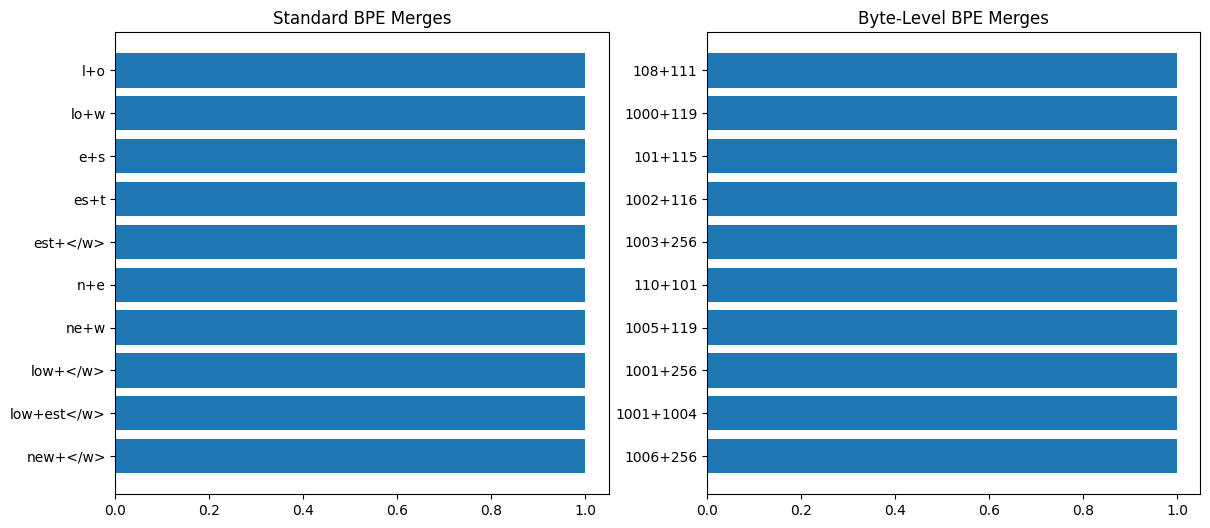

In [ ]:
import re
from collections import Counter
import matplotlib.pyplot as plt


# -------------------------
# Helper: Get vocabulary with counts
# -------------------------
def get_vocab(corpus):
    vocab = Counter()
    for word in corpus:
        symbols = list(word) + ["</w>"]   # word-ending symbol
        vocab[tuple(symbols)] += 1
    return vocab


# -------------------------
# Merge most frequent pair
# -------------------------
def merge_vocab(vocab, pair):
    new_vocab = Counter()
    bigram = re.escape(' '.join(pair))
    pattern = re.compile(r'(?<!\S)' + bigram + r'(?!\S)')

    for word, freq in vocab.items():
        word_str = ' '.join(word)
        new_word_str = pattern.sub(''.join(pair), word_str)
        new_word = tuple(new_word_str.split())
        new_vocab[new_word] = freq
    return new_vocab


# -------------------------
# Standard BPE
# -------------------------
def standard_bpe(corpus, num_merges=10):
    vocab = get_vocab(corpus)
    merges = []

    for _ in range(num_merges):
        # Count pairs
        pairs = Counter()
        for word, freq in vocab.items():
            for i in range(len(word)-1):
                pairs[(word[i], word[i+1])] += freq
        if not pairs:
            break
        best = pairs.most_common(1)[0][0]
        vocab = merge_vocab(vocab, best)
        merges.append(best)
    return vocab, merges


# -------------------------
# Byte-Level BPE
# -------------------------
def byte_level_bpe(text, num_merges=10):
    # Step 1: Represent each character as a byte
    tokens = [list(word.encode("utf-8")) + [256] for word in text]  # 256 = </w>
    vocab = Counter(tuple(t) for t in tokens)

    merges = []
    for _ in range(num_merges):
        pairs = Counter()
        for word, freq in vocab.items():
            for i in range(len(word)-1):
                pairs[(word[i], word[i+1])] += freq
        if not pairs:
            break
        best = pairs.most_common(1)[0][0]
        new_vocab = Counter()
        for word, freq in vocab.items():
            merged = []
            i = 0
            while i < len(word):
                if i < len(word)-1 and (word[i], word[i+1]) == best:
                    merged.append(1000 + len(merges))  # new fake token id
                    i += 2
                else:
                    merged.append(word[i])
                    i += 1
            new_vocab[tuple(merged)] += freq
        vocab = new_vocab
        merges.append(best)
    return vocab, merges


# -------------------------
# Visualization
# -------------------------
def visualize_bpe(corpus):
    # Run Standard BPE
    std_vocab, std_merges = standard_bpe(corpus, num_merges=10)

    # Run Byte-Level BPE
    byte_vocab, byte_merges = byte_level_bpe(corpus, num_merges=10)

    # Plot merge steps
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    ax[0].set_title("Standard BPE Merges")
    ax[0].barh(range(len(std_merges)), [1]*len(std_merges))
    ax[0].set_yticks(range(len(std_merges)))
    ax[0].set_yticklabels([f"{a}+{b}" for a,b in std_merges])
    ax[0].invert_yaxis()

    ax[1].set_title("Byte-Level BPE Merges")
    ax[1].barh(range(len(byte_merges)), [1]*len(byte_merges))
    ax[1].set_yticks(range(len(byte_merges)))
    ax[1].set_yticklabels([f"{a}+{b}" for a,b in byte_merges])
    ax[1].invert_yaxis()

    plt.show()


# -------------------------
# Example usage
# -------------------------
corpus = ["low", "lowest", "new", "newer", "widest"]
visualize_bpe(corpus)

### Creating Input–Target Pairs

After we have a tokenized dataset (from the BPE tokenizer we built earlier), the next step is to structure the data so that it can be used for next-word prediction training.

An LLM doesn’t just memorize tokens — it learns to predict the next token given a context. That’s why we must explicitly create input sequences (contexts) and target tokens (the next word/character/subword).

In this section we implement a data loader that fetches the input-target pairs using a sliding window approach.
To get started, we will first tokenize the whole The Verdict short story we worked with earlier using the BPE tokenizer introduced in the previous section:

In [ ]:

# Encode using BPE tokenizer from previous section
enc_text = tokenizer.encode(raw_text)
print("Total number of tokens in dataset:", len(enc_text))

Total number of tokens in dataset: 5145


**Cropping for Demonstration**

To make the example more illustrative, we remove the first 50 tokens. This ensures we’re working with a slightly later passage in the story where the text flows naturally.

In [ ]:
# Remove first 50 tokens for a more interesting example
enc_sample = enc_text[50:]
print("New dataset length after cropping:", len(enc_sample))

New dataset length after cropping: 5095


One of the easiest and most intuitive ways to create the input-target pairs for the nextword prediction task is to create two variables, x and y, where x contains the input tokens and y contains the targets, which are the inputs shifted by 1:
The context size determines how many tokens are included in the input

In [ ]:
context_size = 4 #length of the input
#The context_size of 4 means that the model is trained to look at a sequence of 4 words (or tokens)
#to predict the next word in the sequence.
#The input x is the first 4 tokens [1, 2, 3, 4], and the target y is the next 4 tokens [2, 3, 4, 5]

x = enc_sample[:context_size]
y = enc_sample[1:context_size+1]

print(f"x: {x}")
print(f"y:      {y}")

x: [290, 4920, 2241, 287]
y:      [4920, 2241, 287, 257]


**Building Context–Target Pairs (Numeric)**

We can now explicitly see how inputs map to targets.

In [ ]:
for i in range(1, context_size+1):
    context = enc_sample[:i]     # growing context
    desired = enc_sample[i]      # next token
    print(context, "---->", desired)

[290] ----> 4920
[290, 4920] ----> 2241
[290, 4920, 2241] ----> 287
[290, 4920, 2241, 287] ----> 257


Everything left of the arrow (---->) refers to the input an LLM would receive, and the token ID on the right side of the arrow represents the target token ID that the LLM is supposed to predict.
For illustration purposes, let's repeat the previous code but convert the token IDs into text:

In [ ]:

for i in range(1, context_size+1):
    context = enc_sample[:i]
    desired = enc_sample[i]

    print(tokenizer.decode(context), "---->", tokenizer.decode([desired]))

 and ---->  established
 and established ---->  himself
 and established himself ---->  in
 and established himself in ---->  a


**Why This Matters (Conceptual Insights)**

*Shifted Targets*

This shifting mechanism ensures the model learns sequential dependencies.

Every input sequence has its target as the very next token.

*Growing Context*

With context_size=4, we can see how the amount of history provided changes predictions.

Larger context sizes allow models to capture longer dependencies.

*Scaling Up*

In real training, we slide this window over the entire dataset (not just 4 tokens) to produce thousands of input–target pairs.

This is the basis of autoregressive training.

**Visualization with Matplotlib**

Let’s visualize the context vs. target relationship.
We’ll mark contexts as sequences of tokens and their corresponding targets.

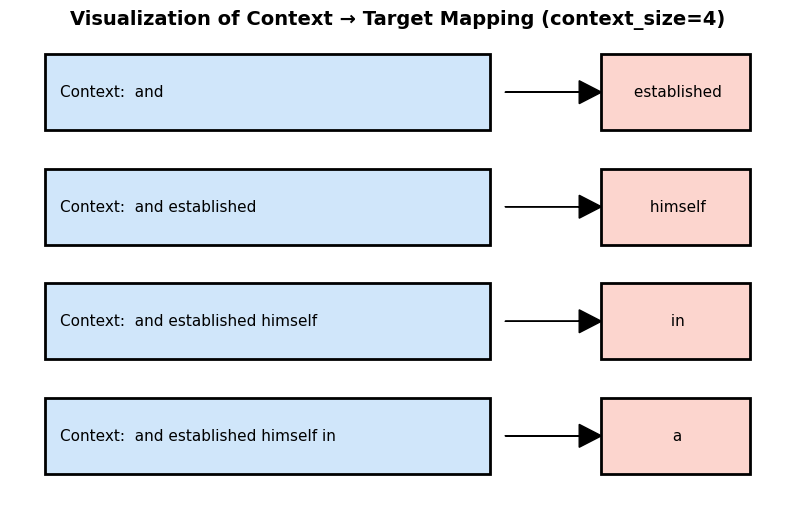

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Prepare pairs for visualization
pairs = []
for i in range(1, context_size+1):
    context = tokenizer.decode(enc_sample[:i])
    target = tokenizer.decode([enc_sample[i]])
    pairs.append((context, target))

fig, ax = plt.subplots(figsize=(10, 6))

# Hide axes
ax.axis("off")

# Vertical spacing between steps
y_start = 0
y_step = -1.5

for i, (context, target) in enumerate(pairs):
    y = y_start + i * y_step

    # Draw context box
    context_box = patches.Rectangle((0, y), 6, 1, edgecolor="black", facecolor="#d0e6fa", lw=2)
    ax.add_patch(context_box)
    ax.text(0.2, y+0.5, f"Context: {context}", fontsize=11, va="center", ha="left")

    # Draw arrow
    ax.arrow(6.2, y+0.5, 1.0, 0, head_width=0.3, head_length=0.3, fc="black", ec="black")

    # Draw target box
    target_box = patches.Rectangle((7.5, y), 2, 1, edgecolor="black", facecolor="#fcd5ce", lw=2)
    ax.add_patch(target_box)
    ax.text(8.5, y+0.5, f"{target}", fontsize=11, va="center", ha="center")

# Title
plt.title("Visualization of Context → Target Mapping (context_size=4)", fontsize=14, weight="bold")
plt.show()

### IMPLEMENTING A DATA LOADER

<div class="alert alert-block alert-success">
For the efficient data loader implementation, we will use PyTorch's built-in Dataset and
DataLoader classes.</div>

<div class="alert alert-block alert-info">
    
Step 1: Tokenize the entire text
    
Step 2: Use a sliding window to chunk the book into overlapping sequences of max_length

Step 3: Return the total number of rows in the dataset

Step 4: Return a single row from the dataset
</div>

In [ ]:
from torch.utils.data import Dataset, DataLoader


class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        # Tokenize the entire text
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})

        # Use a sliding window to chunk the book into overlapping sequences of max_length
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

<div class="alert alert-block alert-warning">

The GPTDatasetV1 class in listing 2.5 is based on the PyTorch Dataset class.

It defines how individual rows are fetched from the dataset.

Each row consists of a number of
token IDs (based on a max_length) assigned to an input_chunk tensor.

The target_chunk
tensor contains the corresponding targets.

I recommend reading on to see how the data
returned from this dataset looks like when we combine the dataset with a PyTorch
DataLoader -- this will bring additional intuition and clarity.
    
</div>

<div class="alert alert-block alert-success">
The following code will use the GPTDatasetV1 to load the inputs in batches via a PyTorch
DataLoader:</div>

<div class="alert alert-block alert-info">
    
Step 1: Initialize the tokenizer

Step 2: Create dataset

Step 3: drop_last=True drops the last batch if it is shorter than the specified batch_size to prevent loss spikes
during training

Step 4: The number of CPU processes to use for preprocessing
    
</div>

In [ ]:
def create_dataloader_v1(txt, batch_size=4, max_length=256,
                         stride=128, shuffle=True, drop_last=True,
                         num_workers=0):

    # Initialize the tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")

    # Create dataset
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)

    # Create dataloader
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers
    )

    return dataloader

<div class="alert alert-block alert-success">
    
Let's test the dataloader with a batch size of 1 for an LLM with a context size of 4,

This will develop an intuition of how the GPTDatasetV1 class and the
create_dataloader_v1 function work together: </div>

In [ ]:
with open("the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()

<div class="alert alert-block alert-info">
    
Convert dataloader into a Python iterator to fetch the next entry via Python's built-in next() function
    
</div>

In [ ]:
import torch
print("PyTorch version:", torch.__version__)
dataloader = create_dataloader_v1(
    raw_text, batch_size=1, max_length=4, stride=1, shuffle=False
)

data_iter = iter(dataloader)
first_batch = next(data_iter)
print(first_batch)

PyTorch version: 2.8.0+cu126
[tensor([[  40,  367, 2885, 1464]]), tensor([[ 367, 2885, 1464, 1807]])]


<div class="alert alert-block alert-warning">

The first_batch variable contains two tensors: the first tensor stores the input token IDs,
and the second tensor stores the target token IDs.

Since the max_length is set to 4, each of the two tensors contains 4 token IDs.

Note that an input size of 4 is relatively small and only chosen for illustration purposes. It is common to train LLMs with input sizes of at least
256.
    
</div>

<div class="alert alert-block alert-success">
    
To illustrate the meaning of stride=1, let's fetch another batch from this dataset: </div>

In [ ]:
second_batch = next(data_iter)
print(second_batch)

[tensor([[ 367, 2885, 1464, 1807]]), tensor([[2885, 1464, 1807, 3619]])]


<div class="alert alert-block alert-warning">

If we compare the first with the second batch, we can see that the second batch's token
IDs are shifted by one position compared to the first batch.

For example, the second ID in
the first batch's input is 367, which is the first ID of the second batch's input.

The stride
setting dictates the number of positions the inputs shift across batches, emulating a sliding
window approach
    
</div>

<div class="alert alert-block alert-warning">

Batch sizes of 1, such as we have sampled from the data loader so far, are useful for
illustration purposes.
                                                                                 
If you have previous experience with deep learning, you may know
that small batch sizes require less memory during training but lead to more noisy model
updates.

Just like in regular deep learning, the batch size is a trade-off and hyperparameter
to experiment with when training LLMs.
    
</div>

<div class="alert alert-block alert-success">
    
Before we move on to the two final sections of this chapter that are focused on creating
the embedding vectors from the token IDs, let's have a brief look at how we can use the
data loader to sample with a batch size greater than 1: </div>

In [ ]:
dataloader = create_dataloader_v1(raw_text, batch_size=8, max_length=4, stride=4, shuffle=False)

data_iter = iter(dataloader)
inputs, targets = next(data_iter)
print("Inputs:\n", inputs)
print("\nTargets:\n", targets)

Inputs:
 tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])

Targets:
 tensor([[  367,  2885,  1464,  1807],
        [ 3619,   402,   271, 10899],
        [ 2138,   257,  7026, 15632],
        [  438,  2016,   257,   922],
        [ 5891,  1576,   438,   568],
        [  340,   373,   645,  1049],
        [ 5975,   284,   502,   284],
        [ 3285,   326,    11,   287]])


<div class="alert alert-block alert-info">
    
Note that we increase the stride to 4. This is to utilize the data set fully (we don't skip a
single word) but also avoid any overlap between the batches, since more overlap could lead
to increased overfitting.
    
</div>

### CREATING TOKEN EMBEDDINGS

<div class="alert alert-block alert-success">
    
Let's illustrate how the token ID to embedding vector conversion works with a hands-on
example. Suppose we have the following four input tokens with IDs 2, 3, 5, and 1:</div>

In [ ]:
input_ids = torch.tensor([2, 3, 5, 1])


<div class="alert alert-block alert-success">
    
For the sake of simplicity and illustration purposes, suppose we have a small vocabulary of
only 6 words (instead of the 50,257 words in the BPE tokenizer vocabulary), and we want
to create embeddings of size 3 (in GPT-3, the embedding size is 12,288 dimensions):

</div>

<div class="alert alert-block alert-success">
    
Using the vocab_size and output_dim, we can instantiate an embedding layer in PyTorch,
setting the random seed to 123 for reproducibility purposes:

</div>

In [ ]:
vocab_size = 6
output_dim = 3

torch.manual_seed(123)
embedding_layer = torch.nn.Embedding(vocab_size, output_dim)

<div class="alert alert-block alert-info">
    
The print statement in the code prints the embedding layer's underlying
weight matrix:
    
</div>

In [ ]:
print(embedding_layer.weight)


Parameter containing:
tensor([[ 0.3374, -0.1778, -0.1690],
        [ 0.9178,  1.5810,  1.3010],
        [ 1.2753, -0.2010, -0.1606],
        [-0.4015,  0.9666, -1.1481],
        [-1.1589,  0.3255, -0.6315],
        [-2.8400, -0.7849, -1.4096]], requires_grad=True)


<div class="alert alert-block alert-info">
    
We can see that the weight matrix of the embedding layer contains small, random values.
These values are optimized during LLM training as part of the LLM optimization itself, as we
will see in upcoming chapters. Moreover, we can see that the weight matrix has six rows
and three columns. There is one row for each of the six possible tokens in the vocabulary.
And there is one column for each of the three embedding dimensions.
    
</div>

<div class="alert alert-block alert-success">
    
After we instantiated the embedding layer, let's now apply it to a token ID to obtain the
embedding vector:

</div>

In [ ]:
print(embedding_layer(torch.tensor([3])))


tensor([[-0.4015,  0.9666, -1.1481]], grad_fn=<EmbeddingBackward0>)


<div class="alert alert-block alert-info">
    
If we compare the embedding vector for token ID 3 to the previous embedding matrix, we
see that it is identical to the 4th row (Python starts with a zero index, so it's the row
corresponding to index 3). In other words, the embedding layer is essentially a look-up
operation that retrieves rows from the embedding layer's weight matrix via a token ID.
    
</div>

<div class="alert alert-block alert-success">
    
Previously, we have seen how to convert a single token ID into a three-dimensional
embedding vector. Let's now apply that to all four input IDs we defined earlier
(torch.tensor([2, 3, 5, 1])):

</div>

In [ ]:
print(embedding_layer(input_ids))


tensor([[ 1.2753, -0.2010, -0.1606],
        [-0.4015,  0.9666, -1.1481],
        [-2.8400, -0.7849, -1.4096],
        [ 0.9178,  1.5810,  1.3010]], grad_fn=<EmbeddingBackward0>)


<div class="alert alert-block alert-info">
    
Each row in this output matrix is obtained via a lookup operation from the embedding
weight matrix
    
</div>

**POSITIONAL EMBEDDINGS (ENCODING WORD POSITIONS)**

In [ ]:
vocab_size = 50257
output_dim = 256

token_embedding_layer = torch.nn.Embedding(vocab_size, output_dim)

In [ ]:
max_length = 4
dataloader = create_dataloader_v1(
    raw_text, batch_size=8, max_length=max_length,
    stride=max_length, shuffle=False
)
data_iter = iter(dataloader)
inputs, targets = next(data_iter)

In [ ]:
print("Token IDs:\n", inputs)
print("\nInputs shape:\n", inputs.shape)

Token IDs:
 tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])

Inputs shape:
 torch.Size([8, 4])


In [ ]:
token_embeddings = token_embedding_layer(inputs)
print(token_embeddings.shape)

torch.Size([8, 4, 256])


In [ ]:
context_length = max_length
pos_embedding_layer = torch.nn.Embedding(context_length, output_dim)

In [ ]:
pos_embeddings = pos_embedding_layer(torch.arange(max_length))
print(pos_embeddings.shape)

torch.Size([4, 256])


In [ ]:
input_embeddings = token_embeddings + pos_embeddings
print(input_embeddings.shape)

torch.Size([8, 4, 256])
